## Document Classification.

### Problem Statement
We process documents related to mortgages, aka everything that happens to originate a mortgage that you don't see as a borrower. Often times the only access to a document we have is a scan of a fax of a print out of the document. Our system is able to read and comprehend that document, turning a PDF into structured business content that our customers can act on.

This dataset represents the output of the OCR stage of our data pipeline. Since these documents are sensitive financial documents we have not provided you with the raw text that was extracted. Instead we have had to obscure the data. Each word in the source is mapped to one unique value in the output. If the word appears in multiple documents then that value will appear multiple times. The word order for the dataset comes directly from our OCR layer, so it should be roughly in order.

In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import chi2
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.naive_bayes import MultinomialNB
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.feature_selection import SelectKBest
from sklearn.calibration import CalibratedClassifierCV
from sklearn.feature_selection import chi2
from sklearn.pipeline import Pipeline

In [2]:
df = pd.read_csv("shuffled-full-set-hashed.csv", header = None)
df.columns = ['Category', 'Content']
display(df.head())
print("Shape of data is : {}".format(df.shape))

,Category,Content
0,DELETION OF INTEREST,e04a09c87692 d6b72e591b91 5d066f0246f1 ed41171...
1,RETURNED CHECK,a3b334c6eefd be95012ebf2b 41d67080e078 ff1c26e...
2,BILL,586242498a88 9ccf259ca087 54709b24b45f 6bf9c0c...
3,BILL,cd50e861f48b 6ca2dd348663 d38820625542 f077614...
4,BILL,9db5536263d8 1c303d15eb65 3f89b4673455 b73e657...


Shape of data is : (62204, 2)


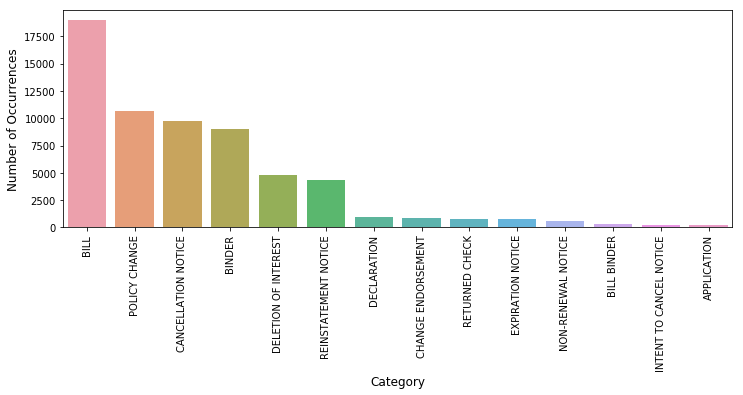

BILL                       18968
POLICY CHANGE              10627
CANCELLATION NOTICE         9731
BINDER                      8973
DELETION OF INTEREST        4826
REINSTATEMENT NOTICE        4368
DECLARATION                  968
CHANGE ENDORSEMENT           889
RETURNED CHECK               749
EXPIRATION NOTICE            734
NON-RENEWAL NOTICE           624
BILL BINDER                  289
INTENT TO CANCEL NOTICE      229
APPLICATION                  229
Name: Category, dtype: int64


In [3]:
cnt_categories = df['Category'].value_counts()

plt.figure(figsize=(12,4))
g = sns.barplot(cnt_categories.index, cnt_categories.values, alpha=0.9)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Category', fontsize=12)
plt.xticks(rotation=90)

plt.show()
print(cnt_categories)

In NLP, we pre-process data by removing stop words, changing the text to lower case, stemming, lemmatization. In our dataset, we cannot do these steps as the words are encoded. Hence, we will calculate Tf-IDF for all the words and use that as the feature for our classification.  The max-df value will act as a regularizing factor for our dataset. Setting a max-df and min-df value will allow our model to generalize. We will do cross-validation to evaluate the models.

In [4]:
# term frquency and document frequency vectorizer. Max_df and Min_df will filter out 
# terms that are very common(present in more than 54% of documents) or very rare(present in less than 1% documents)
# we will consider both 1 gram and 2 grams.
tfidf = TfidfVectorizer(sublinear_tf=True, max_df = 0.54, min_df = 0.01, norm='l2', ngram_range=(1, 2))

features = tfidf.fit_transform(df['Content'].values.astype('U')).toarray()
labels = df['Category']
all_categories = np.unique(labels)
features.shape

(62204, 3667)

We will analyze what most correlated unigrams and bigrams for each of the categories are. Although the words are encoded, we can check which words are more correlated to each of the classes, if we can decode those words back to original English words we can validate it.

In [5]:
N = 2
categories = []
most_corelated_unigrams = []
most_corelated_bigrams = []
for category_id in all_categories:
    features_chi2 = chi2(features, labels == category_id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    categories.append(category_id)
    most_corelated_unigrams.append(unigrams[-N:])
    most_corelated_bigrams.append(bigrams[-N:])

pd.DataFrame({'Category' : categories, 'Most corelated unigrams' : most_corelated_unigrams, 
              'Most corelated bigrams' : most_corelated_bigrams})

,Category,Most corelated unigrams,Most corelated bigrams
0,APPLICATION,"[823d2be57c98, 4298762de22f]","[8b0131ee1005 8b0131ee1005, 1fe62f2b2bff 9de56..."
1,BILL,"[d19b1c129f40, 641356219cbc]","[f95d0bea231b 21e314d3afcc, b9699ce57810 64135..."
2,BILL BINDER,"[93e786b92f57, 28b12e45914e]","[7d9e333a86da 360e8b28421c, fbe267908bc5 2f254..."
3,BINDER,"[388cbcf48919, d8535c18626a]","[6b343f522f78 d8535c18626a, d8535c18626a d3882..."
4,CANCELLATION NOTICE,"[79f872a2e298, 98d0d51b397c]","[b9699ce57810 98d0d51b397c, 98d0d51b397c eeb86..."
5,CHANGE ENDORSEMENT,"[1a46ce1e6826, 29b62a6f238b]","[458fb753e194 4e7b1501a15b, e616d3a38f90 29b62..."
6,DECLARATION,"[36d909566e5c, f36858486ddc]","[7d9e333a86da 360e8b28421c, 586242498a88 b7853..."
7,DELETION OF INTEREST,"[6b223a390d86, d774c0d219f8]","[ba02159e05b1 892d541c89eb, 6b223a390d86 6ce6c..."
8,EXPIRATION NOTICE,"[0e60c8ecc79d, 3bfb91f64987]","[094453b4e4ae 586242498a88, b9699ce57810 5d764..."
9,INTENT TO CANCEL NOTICE,"[74c7b4b972ff, 66b4e66655f9]","[d493c688fb66 07b93136ac77, eb562127f33e c0ed5..."


Next step is we will try out a few models LinearSVC(), LogisticRegression(), MultinomialNB() with five-fold cross-validation and check the results. The model which gives best average accuracy we will use the parameters of that model to create the pipelines and deploy the model.

In [6]:
# We will try a few models
models = [
    LinearSVC(),
    LogisticRegression(random_state=0),
    MultinomialNB()
]

# 5 fold cross validation
CV = 5

entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
        
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

c:\users\amandeep\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\amandeep\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
c:\users\amandeep\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\amandeep\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warn

In [ ]:
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

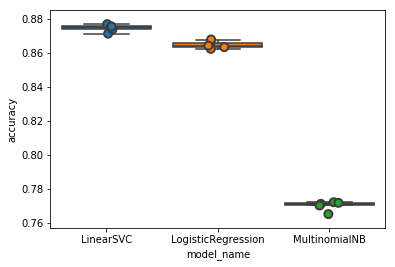

As we can see above LinearSVC is giving best results in terms of accuracy. We will deploy the linearSVC model.

In [ ]:
model = Linea

In [8]:
model = LinearSVC()
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, 
                                                                                 test_size=0.2, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
conf_mat = confusion_matrix(y_test, y_pred)
print(accuracy_score(y_test, y_pred))

0.8729201832650109


In [22]:
conf_mat

array([[  23,    3,    0,    7,    0,    1,    0,    0,    0,    0,    0,
           7,    0,    0],
       [   4, 3428,    7,   54,  172,    0,    8,    0,    5,    4,    0,
         114,    5,    1],
       [   0,   31,    6,    5,    0,    0,    0,    0,    0,    0,    0,
          15,    0,    0],
       [   1,   54,    0, 1627,    5,    3,   10,    2,    0,    1,    0,
         136,    2,    0],
       [   0,  109,    0,   13, 1735,    0,    2,   47,    2,    4,    6,
          34,   27,    0],
       [   0,    0,    0,    1,    1,  156,    1,    0,    1,    0,    0,
          23,    0,    0],
       [   0,   40,    0,   76,   10,    0,   41,    9,    1,    1,    1,
          35,    0,    1],
       [   0,    2,    0,    5,   62,    3,    0,  828,    0,    0,    0,
           6,    1,    0],
       [   0,   22,    0,    1,    3,    0,    0,    0,   99,    0,    2,
           4,    1,    0],
       [   0,   16,    0,    1,    4,    0,    2,    1,    0,   34,    1,
           0,    

In [26]:
new_conf_mat = []
for i in range(len(conf_mat[0])):
    actual_value = sum(conf_mat[i])
    new_conf_mat.append([])
    for j in range(len(conf_mat[0])):
        val = conf_mat[i][j]
        new_conf_mat[i].append(val/actual_value * 100)
        
new_conf_mat = np.array(new_conf_mat)

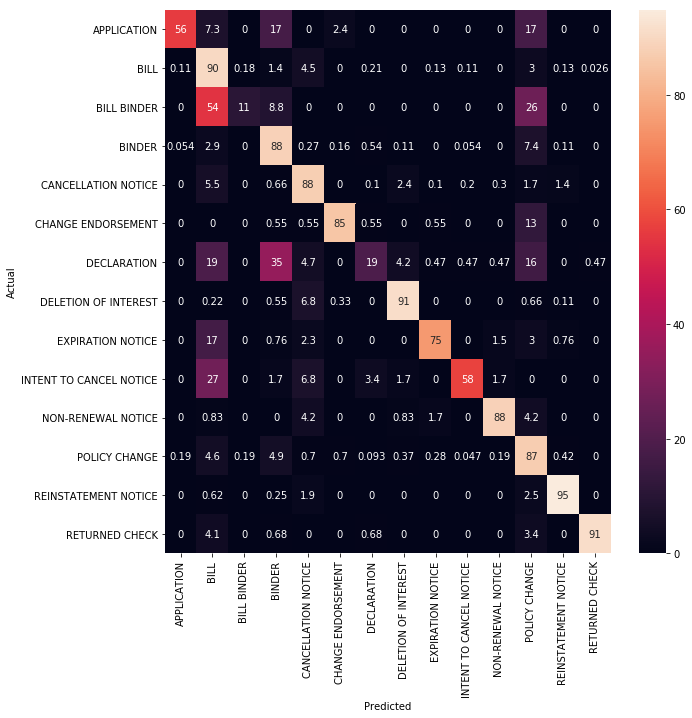

In [28]:
fig, ax = plt.subplots(figsize=(10,10))
category_ids = df.groupby(['Category']).count().index
sns.heatmap(new_conf_mat, annot=True,
           xticklabels=category_ids, yticklabels=category_ids)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

The model gives an accuracy of around 87.5% on the validation data. We will use the parameters that we trained above and create a pipeline for training, deploying, and testing the model. This pipeline is similar to data pipelines we usually should have. The model creation process we did earlier be used to get the optimum hyperparameters and model types. In our case hyperparameters are max_df and min_df we set to the tfidf vectorizer.

In [10]:
# train a small model first and test.
(features_train, labels_train) = (df.loc[:, 'Content'].values.astype('U'), df.loc[:, 'Category'])
#(features_train, labels_train) = (df.loc[:, 'Content'].values.astype('U'), df.loc[:, 'Category'])

### TfidfVectorizer
tfidfv = TfidfVectorizer(ngram_range=(1, 2), min_df=0.01, max_df=0.54, norm='l2')

## Selector.
selector = SelectKBest(chi2, k=1000)

## Linear SVC model.
linear_svc = LinearSVC()

calibrated_svc = CalibratedClassifierCV(linear_svc, method='sigmoid')

linearsvc = Pipeline([('vect', tfidfv),
                      ('selector', selector),
                      ('clf', calibrated_svc),
                      ])

linearsvc.fit(features_train, labels_train)
from sklearn.externals import joblib
joblib.dump(linearsvc, 'Flask_Application/model.pkl')

c:\users\amandeep\appdata\local\programs\python\python37\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


['Flask_Application/model.pkl']

In [11]:
from sklearn.externals import joblib
classifier = open('Flask_Application/model.pkl', 'rb')
model = joblib.load(classifier)

Let us try to load the model and test the predictions for a few contents.

In [12]:
print(model.predict([df.iloc[11]['Content']]))
model.predict_proba([df.iloc[11]['Content']]).max()

['POLICY CHANGE']


0.7532011477593662

In [13]:
print(df.iloc[10001]['Category'])
df.iloc[10001]['Content']

BINDER


'586242498a88 d38820625542 da505f293d44 4ffb12504ac6 001d14749524 5ffca64090ab ec3406979928 6ca2dd348663 099cce6666b2 98d0d51b397c bdbe553166a7 6ca2dd348663 6b343f522f78 98734c94f387 f0666bdbc8a5 98734c94f387 b13cff832743 b208ae1e8232 eeb86a6a04e4 afaf4c07801f fbb5efbcc5b3 6b343f522f78 d8535c18626a 6ca2dd348663 cf6e30467290 586242498a88 a3008b19a353 cc707138ce34 ec3406979928 e1b9e4df3a88 4eb37245db2f e4dad7cb07b6 d38820625542 7498a1e9d9d7 ac624879ac84 96501dd91789 d38820625542 d8535c18626a d8bea9a1e58a 2d00e7e4d33f 788f5286a397 e943e5e5b779 cf6e30467290 eeb86a6a04e4 6ca2dd348663 377a21b394dc d38820625542 894af811cc5b 85bf198ebad1 0a73937a5263 35991d8609e2 133d46f7ed38 4ffb12504ac6 d8535c18626a 8c8e77081f2f 92d786bfe2a5 ffe8decfd82e 98d0d51b397c 019a80c31e1b 5c02c2aaa67b 6fd647aa15b8 d51a4a0ad862 d8535c18626a 034e2d7f187e 6d10c76d455a 87b8193a0183 d8535c18626a d38820625542 422068f04236 58b1c79289d7 c0ab098d4399 07315ce641ce 04503bc22789 b461e3e78b30 c99bb13b5e17 6ef2ade170d9 c8f5ad40a68